In [1]:
%pylab inline
import pickle
import fitsio
# from astropy.io import fits
import pickle
from astropy.table import Table
import numpy as np
from scipy.signal import savgol_filter

Populating the interactive namespace from numpy and matplotlib


In [2]:
def smooth(flux, n=31):
    """
    Smooths the noise from a given spectrum using the scipy function savgol_filter
    Args:
        flux : an array of the flux values for a single spectrum
    Options:
        n : 
    """
    return savgol_filter(flux, n, polyorder=3)

In [3]:
def plot_spectra(nums, fluxes, alpha=0.7, bin_size=0.0001):
    """
    Plots NUMS spectra from FLUXES
    Args:
        nums : an array specifying which spectra to plot
        fluxes : a 2D array where each element is an array of the flux values for a given spectrum
    Options:
        alpha
        bin_size
    """
    if len(nums) == 0:
        return
    num_xbins = len(fluxes[0])
    for i in nums:
        #- smooths out the ith spectrum
        smoothed = smooth(fluxes[i])
        plot(np.arange(num_xbins)*bin_size, smoothed, alpha=alpha)

In [4]:
def read_spectrum(plate, mjd, fiber):
    """
    Reads in spectra as astropy Tables
    Args:
        plate
        mjd
        fiber
    """
    basedir = '/global/cfs/cdirs/cosmo/data/sdss/dr16/eboss/spectro/redux/v5_13_0/spectra/full'
    specfile = '{basedir}/{plate}/spec-{plate}-{mjd}-{fiber:04d}.fits'.format(
        basedir=basedir, plate=plate, mjd=mjd, fiber=fiber)
    
    try:
        tbl = Table(fitsio.read(specfile, 'COADD', columns=['flux', 'ivar', 'and_mask', 'loglam']))
    except:
        tbl = Table(fitsio.read(specfile, columns=['flux', 'ivar', 'and_mask', 'loglam']))
        tbl.rename_column('FLUX', 'flux')
        tbl.rename_column('IVAR', 'ivar')
        tbl.rename_column('AND_MASK', 'and_mask')
        tbl.rename_column('LOGLAM', 'loglam')
        
    return tbl
    # return Table(fitsio.read(specfile, 'COADD', columns=['flux', 'ivar', 'and_mask', 'loglam']))

In [5]:
def add_rest_loglams(spectrum, z):
    """
    Adds the log of the rest wavelengths for a given spectrum
    Args:
        spectrum : the number of a given spectrum used to obtain the redshift from the QSO catalog
        z : the redshift of spectrum
    Returns:
        Astropy table object of spectrum with added logarithmic rest wavelengths
    """    
    #- defines an array of the logs of the observed wavelengths for a spectrum
    loglams = np.array(spectrum['loglam'])
    #- calculates the rest-frame wavelengths on a logarithmic scale
    rest_loglams = loglams - np.log10(1+z)

    #- adds a truncated rest_loglams column to the table of the given spectrum
    spectrum['rest_loglams'] = np.around(rest_loglams, 4)
    return spectrum

In [6]:
def rest_loglam_offset(spectrum, rest_loglam_base, bin_size=0.0001):
    """
    Bins the logarithmic rest wavelengths of the spectra into enumerated offset bins
    Args:
        spectrum : an array of fluxes for a single spectrum
        rest_loglam_base :
    Options:
        bin_size

    Returns:
        Astropy table object of spectrum with added offset bins
    """
    rest_loglams = np.array(spectrum['rest_loglams'])
    #- constructs an array of differences between the rest wavelengths and the base rest wavelength
    rest_loglam_diffs = rest_loglams - rest_loglam_base
    #- counts the number of bins between each observed wavelength and the base
    num_bins_offset = rest_loglam_diffs / bin_size
    #- adds an offset_bins column to the spectrum table
    spectrum['offset_bins'] = np.round(num_bins_offset).astype(int)
    return spectrum

In [7]:
def construct_arrays(spectrum, num_bins):
    '''
    Constructs flux and ivar arrays for a given spectrum
    Assigns flux values where and_mask != 0 to a weight of 0 in ivar

    Returns:
        flux and ivar arrays
    '''
    #- creates an empty array of zeros
    flux_array = np.zeros(num_bins)
    ivar_array = np.zeros(num_bins)

    #- for each (offset_bin, flux) pair, add it to the 2D array
    #- likewise for ivar
    for i in range(len(spectrum['offset_bins'])):
        flux_array[spectrum['offset_bins'][i]] = spectrum['flux'][i]

        #- ensure that any flux values where and_mask != 0 is weighted to value 0
        if spectrum['and_mask'][i]:
            ivar_array[spectrum['offset_bins'][i]] = 0
        else:
            ivar_array[spectrum['offset_bins'][i]] = spectrum['ivar'][i]

    return flux_array, ivar_array

In [8]:
def normalize(fluxes, ivars, spec, i_array, num_normalized):
    """
    For each spectrum, normalizes the flux with respect to the other spectra
    - All transformations to the fluxes are also applied to the inverse variances

    Args:
        fluxes : a 2D array where each element corresponds to an array of the flux values for a different spectrum
        ivars  : a 2D array where each element corresponds to an array of the ivar values for a different spectrum
        spec : a single spectrum (array of fluxes) to be normalized
        i_array : the corresponding ivars to SPEC
        num_normalized : the number of spectra already normalized thus far
        
    Returns normalized spectrum and corresponding inverse variance array
    """
    #- get bounds
    nonzeros = np.flatnonzero(spec)
    start_spec = nonzeros[0]
    end_spec = nonzeros[-1]

    mean_spec = np.sum(spec)/(end_spec-start_spec)

    agg_mean = np.average(fluxes, weights=ivars)

    #- get scale factor
    scale_factor = mean_spec / agg_mean

    if scale_factor == 0:
        print('ERROR: division by 0 for the {}th spectrum'.format(num_normalized), flush=True)
        #- TODO: make sure this flags such un-normalized spectra
        return

    #- normalize by dividing single spectrum flux by scale factor
    spec = spec / scale_factor
    #- apply all transformations to the ivars
    i_array = i_array * scale_factor**2 

    return spec, i_array

In [9]:
def select_spectra(qsocat, nkeep, nspec):
    """
    Select subset of spectra from QSO Catalog based on a 2D binning scheme which emphasizes greater diversity
        in redshift and color

    Args:
        qsocat : an astropy Table corresponding to a QSO Catalog
        nkeep : the maximum number of spectra from any particular 0.1 x 0.1 redshift-color bin
        nspec : the number of target spectra desired from spectra selection (a goal input for recordkeeping)
        
    Returns a subset of qsocat (of selected spectra) and a np.arange object of spectra indices in the table
    """
    # get colors
    g = np.array(qsocat['PSFMAG'])[:,1]
    r = np.array(qsocat['PSFMAG'])[:,2]
    color = g-r
    
    # color outliers
    ii_outliers = color < -100
    color = color[~ii_outliers]
    qsocat = qsocat[~ii_outliers]

    # redshift outliers
    ii_outliers = qsocat['Z'] < 0
    qsocat = qsocat[~ii_outliers]
    color = color[~ii_outliers]

    assert len(qsocat) == len(color)
    
    
    # 2D binning of redshift and color
    keep_indices = list()
    
    # redshift binning
    for zmin in np.arange(0, 7.0, 0.1):
        zmax = zmin + 0.1
        redshift_ii = (zmin <= qsocat['Z']) & (qsocat['Z'] < zmax)

        # color binning
        for crmin in np.arange(-6, 6, 0.1):
            crmax = crmin + 0.1
            cr_ii = (crmin <= color) & (color < crmax)

            ii = np.where(redshift_ii & cr_ii)[0]
            if len(ii) < nkeep:
                keep_indices.extend(ii)
                # print('only {} for redshifts {}-{}, colors {}-{}'.format(
                    # len(ii), round(zmin, 3), round(zmax, 3),
                    # round(crmin, 3), round(crmax, 3)))
            else:
                # print('randomly selecting for redshifts {}-{}, colors {}-{}'.format(
                    # len(ii), round(zmin, 3), round(zmax, 3),
                    # round(crmin, 3), round(crmax, 3)))
                keep_indices.extend(np.sort(np.random.choice(ii, size=nkeep, replace=False)))
    
    if (len(keep_indices) < nspec):
        print('only {}/{} spectra'.format(len(keep_indices), nspec))
        nspec = len(keep_indices)
    else:
        keep_indices = np.random.choice(keep_indices, size=nspec)
        print('len idxs kept = {}'.format(len(keep_indices)))
    
    qsocat = qsocat[keep_indices]   # get subset of qsocat
    spectra = np.arange(len(qsocat))
    
    return qsocat, spectra

In [10]:
def proc_pipeline(num_spectra, nkeep=200, rlb=2.6, nbins=13500):
    """
    Iterates over all spectra, process and noramlizes data, stores in 2D arrays 
    as class variables
    
    Args:
        num_spectra : 

    Options:
        nkeep : the maximum number of spectra from any particular redshift-color bin for spectra selection
                (default=100)
        rlb : 'rest loglam base' or desired base offset for the log of the rest wavelengths
        nbins : the number of bins in the array of log wavelengths

    Returns fluxes, ivars 2D arrays
    """
    qsocat = Table(fitsio.read('/global/cfs/cdirs/cosmo/data/sdss/dr16/eboss/qso/DR16Q/DR16Q_v4.fits', 1))

    qsocat, spectra = select_spectra(qsocat, nkeep, num_spectra)
    qsocat.sort('Z') # must be in sorted redshift order for correct and effective normalization procedure
    print('Spectra selected')

    #- store in 2D arrays
    fluxes, ivars = [], []

    #- indices kept, skipped
    keep, skipped = [], []

    #- read one spectrum at a time and normalize
    count = 0
    for i in spectra:
        try:
            #- read in spectrum and add offset bins
            spec = read_spectrum(qsocat['PLATE'][i], qsocat['MJD'][i], qsocat['FIBERID'][i])
            spec = add_rest_loglams(spec, qsocat['Z'][i])
            spec = rest_loglam_offset(spec, rlb)

            #- normalize spec
            f_array, i_array = construct_arrays(spec, nbins)

            if count != 0:
                f_array, i_array = normalize(fluxes, ivars, f_array, i_array, count)
            
            if f_array is None or i_array is None:
                skipped.append(i)
                # print('Failed to normalize number {}'.format(i))
                pass

            fluxes.append(f_array)
            ivars.append(i_array)

            keep.append(i)

            count += 1
        except:
            skipped.append(i)
            # print('Passing number {}'.format(i))
            pass

    print('count is ' + str(count))    
    qsocat_new = qsocat[keep]

    return np.array(fluxes), np.array(ivars), qsocat_new, keep, skipped

In [11]:
rest_offset = 2.6
nbins = 14000
min_per_lam=50

### run qsoproc

In [12]:
%%time
fluxes, ivars, qsocat_new, kept_idxs, skipped_idxs = proc_pipeline(30000, nkeep=50, rlb=rest_offset, nbins=nbins)

len idxs kept = 30000
Spectra selected
count is 27723
CPU times: user 11h 3min 14s, sys: 17h 8min 41s, total: 1d 4h 11min 55s
Wall time: 1d 4h 33min 12s


In [14]:
bin_range = np.arange(fluxes.shape[1])
rest_loglam_diffs = bin_range * 0.0001
rest_loglams = np.array(rest_loglam_diffs + rest_offset)

In [15]:
with open("./selected_spectra/fluxes.pkl","wb") as file:
    pickle.dump(fluxes,file)
    
with open("./selected_spectra/ivars.pkl", "wb") as file:
    pickle.dump(ivars, file)

with open("./selected_spectra/rest_loglams.pkl", "wb") as file:
    pickle.dump(rest_loglams, file)

with open("./selected_spectra/kept_idxs.pkl", "wb") as file:
    pickle.dump(kept_idxs, file)

with open("./selected_spectra/skipped_idxs.pkl", "wb") as file:
    pickle.dump(skipped_idxs, file)

qsocat_new.write('./selected_spectra/qsocat0.fits', format='fits', overwrite=True)

In [16]:
assert len(qsocat_new)==fluxes.shape[0]
fluxes.shape

(27723, 14000)

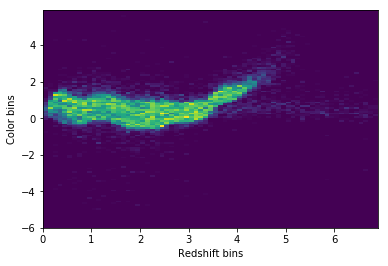

In [17]:
g_final = np.array(qsocat_new['PSFMAG'])[:,1]
r_final = np.array(qsocat_new['PSFMAG'])[:,2]
final_cr = g_final-r_final
plt.hist2d(x=qsocat_new['Z'], y=final_cr, bins=[np.arange(0,7,.1),np.arange(-6,6,.1)]);
plt.xlabel('Redshift bins');
plt.ylabel('Color bins');

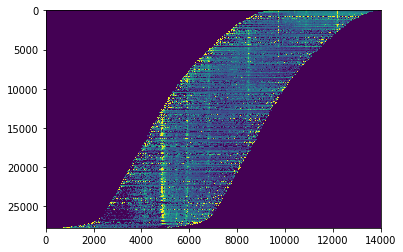

In [18]:
imshow(fluxes, aspect='auto', vmin=0, vmax=2);

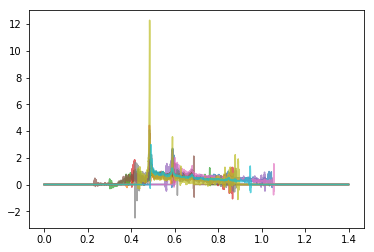

In [19]:
plot_spectra(np.random.choice(np.arange(fluxes.shape[0]), size=10), fluxes)

### Open selected spectra

In [20]:
with open("./selected_spectra/fluxes.pkl","rb") as file:
    fluxes = pickle.load(file)
    
with open("./selected_spectra/ivars.pkl", "rb") as file:
    ivars = pickle.load(file)

with open("./selected_spectra/rest_loglams.pkl", "rb") as file:
    rest_loglams = pickle.load(file)

with open("./selected_spectra/kept_idxs.pkl", "rb") as file:
    kept_idxs = pickle.load(file)

with open("./selected_spectra/skipped_idxs.pkl", "rb") as file:
    skipped_idxs = pickle.load(file)

qsocat_new = Table(fitsio.read('./selected_spectra/qsocat0.fits'))

In [21]:
fluxes.shape

(27723, 14000)

In [22]:
qsocat_new[kept_idxs[0]]

SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,IS_QSO_QN,Z_QN,RANDOM_SELECT,Z_10K,Z_CONF_10K,PIPE_CORR_10K,IS_QSO_10K,THING_ID,Z_VI,Z_CONF,CLASS_PERSON,Z_DR12Q,IS_QSO_DR12Q,Z_DR7Q_SCH,IS_QSO_DR7Q,Z_DR6Q_HW,Z_DR7Q_HW,IS_QSO_FINAL,Z,SOURCE_Z,Z_PIPE,ZWARNING,OBJID,Z_PCA,ZWARN_PCA,DELTACHI2_PCA,Z_HALPHA,ZWARN_HALPHA,DELTACHI2_HALPHA,Z_HBETA,ZWARN_HBETA,DELTACHI2_HBETA,Z_MGII,ZWARN_MGII,DELTACHI2_MGII,Z_CIII,ZWARN_CIII,DELTACHI2_CIII,Z_CIV,ZWARN_CIV,DELTACHI2_CIV,Z_LYA,ZWARN_LYA,DELTACHI2_LYA,Z_LYAWG,Z_DLA [5],NHI_DLA [5],CONF_DLA [5],BAL_PROB,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,BI_SIIV,ERR_BI_SIIV,AI_SIIV,ERR_AI_SIIV,BOSS_TARGET1,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,NSPEC_SDSS,NSPEC_BOSS,NSPEC,PLATE_DUPLICATE [74],MJD_DUPLICATE [74],FIBERID_DUPLICATE [74],SPECTRO_DUPLICATE [74],SKYVERSION,RUN_NUMBER,RERUN_NUMBER,CAMCOL_NUMBER,FIELD_NUMBER,ID_NUMBER,LAMBDA_EFF,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,PSFFLUX [5],PSFFLUX_IVAR [5],PSFMAG [5],PSFMAGERR [5],EXTINCTION [5],M_I,SN_MEDIAN_ALL,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,W1_FLUX,W1_FLUX_IVAR,W1_MAG,W1_MAG_ERR,W1_CHI2,W1_FLUX_SNR,W1_SRC_FRAC,W1_EXT_FLUX,W1_EXT_FRAC,W1_NPIX,W2_FLUX,W2_FLUX_IVAR,W2_MAG,W2_MAG_ERR,W2_CHI2,W2_FLUX_SNR,W2_SRC_FRAC,W2_EXT_FLUX,W2_EXT_FRAC,W2_NPIX,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,JMAG,JMAG_ERR,JSNR,JRDFLAG,HMAG,HMAG_ERR,HSNR,HRDFLAG,KMAG,KMAG_ERR,KSNR,KRDFLAG,SDSS2MASS_SEP,2RXS_ID,2RXS_RA,2RXS_DEC,2RXS_SRC_FLUX,2RXS_SRC_FLUX_ERR,SDSS2ROSAT_SEP,XMM_SRC_ID,XMM_RA,XMM_DEC,XMM_SOFT_FLUX,XMM_SOFT_FLUX_ERR,XMM_HARD_FLUX,XMM_HARD_FLUX_ERR,XMM_TOTAL_FLUX,XMM_TOTAL_FLUX_ERR,XMM_TOTAL_LUM,SDSS2XMM_SEP,GAIA_MATCHED,GAIA_DESIGNATION,GAIA_RA,GAIA_DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,GAIA_PM_RA,GAIA_PM_RA_ERR,GAIA_PM_DEC,GAIA_PM_DEC_ERR,GAIA_G_MAG,GAIA_G_FLUX_SNR,GAIA_BP_MAG,GAIA_BP_FLUX_SNR,GAIA_RP_MAG,GAIA_RP_FLUX_SNR,SDSS2GAIA_SEP
bytes18,float64,float64,int32,int32,int16,bytes6,bytes6,int16,float64,int16,float64,int16,int16,int16,int64,float64,int16,int16,float64,int16,float64,int16,float64,float64,int16,float64,bytes12,float64,int32,bytes19,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int32,int32,int32,int32,int32,int16,int16,uint8,int32,bytes3,int32,int32,int32,float64,float64,float64,float64,bytes14,int32,float64,float32,float64,float32,float64,float32,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,bytes21,float64,float64,float32,float32,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,int16,bytes28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
082842.73+454433.2,127.178063101,45.7425809224,6393,56341,997,QSO,QSO,1,0.0480821214361,0,-1.0,-1,-1,-1,466977192,0.049,3,3,0.0490522459149,1,-1.0,-1,-1.0,-1.0,1,0.049,VI,0.0490447767079,0,1237653587947815102,0.0490486637559,0,77643.1122238,0.0493408787995,0,16014.5796461,0.0492705925515,0,1844.45420115,-1.0,7682,0.0,-1.0,7682,0.0,-1.0,7682,0.0,-1.0,7682,0.0,0.0490487,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,16384,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,-1 .. -1,2,1889,301,4,158,190,5400.0,0.0,277.720092773,56.0211219788,boss204,15305,10.0232000351,20.099 .. 166.969,4.14414691925 .. 0.156198248267,19.242 ..

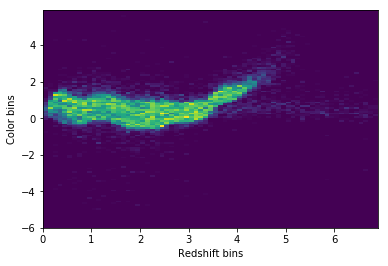

In [23]:
g_final = np.array(qsocat_new['PSFMAG'])[:,1]
r_final = np.array(qsocat_new['PSFMAG'])[:,2]
final_cr = g_final-r_final
plt.hist2d(x=qsocat_new['Z'], y=final_cr, bins=[np.arange(0,7,.1),np.arange(-6,6,.1)]);
plt.xlabel('Redshift bins');
plt.ylabel('Color bins');

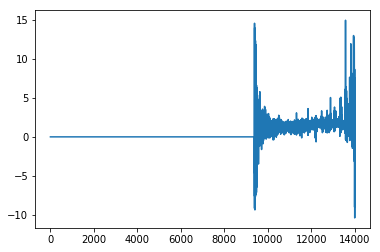

In [24]:
plot(np.arange(len(fluxes[0])), fluxes[0,:]);

**check for wraparound problem**

In [25]:
fluxes[:5,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [26]:
fluxes[-5:-1,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])